In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [37]:
pip install ucimlrepo

In [17]:
from ucimlrepo import fetch_ucirepo
rt_iot2022 = fetch_ucirepo(id=942)

# Data
X = rt_iot2022.data.features
y = rt_iot2022.data.targets


In [18]:
df = pd.concat([X, y], axis=1)  # Make sure y is a Series or adjust accordingly

# Check the first few rows of the dataframe
print(df.head())

# Encoder for the 'Attack_type' column
encoder = LabelEncoder()
df['Attack_type'] = encoder.fit_transform(df['Attack_type'])

# List of feature columns: assuming 'Attack_type' is now the last column
feature_columns = df.columns[:-1]  # All columns except the last one

   id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0      38667       1883   tcp    mqtt      32.011598             9   
1      51143       1883   tcp    mqtt      31.883584             9   
2      44761       1883   tcp    mqtt      32.124053             9   
3      60893       1883   tcp    mqtt      31.961063             9   
4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

   active.std     idle.min     idle.max     idle.tot     idle.avg  idle.std  \
0         0.0  2972

In [20]:
# Assuming 'df' is your DataFrame and it contains categorical features besides 'Attack_type'
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'Attack_type']  # list categorical columns
df = pd.get_dummies(df, columns=categorical_cols)  # This will handle all categorical columns

# Continue with feature and target separation
feature_columns = [col for col in df.columns if col != 'Attack_type']  # Assume 'Attack_type' is the target
X = df[feature_columns]
y = df['Attack_type']

# Encode labels if not already
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to tensors
X_tensor = torch.tensor(X_scaled.astype(np.float32))
y_tensor = torch.tensor(y.astype(np.int64))


In [21]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset into training, validation, and test sets
num_total = len(dataset)
num_train = int(num_total * 0.7)  # 70% of the data for training
num_valid = int(num_total * 0.15)  # 15% for validation
num_test = num_total - num_train - num_valid  # Remaining 15% for testing

train_dataset, valid_dataset, test_dataset = random_split(dataset, [num_train, num_valid, num_test])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [22]:
class IOTClassifier(nn.Module):
    def __init__(self, num_features):
        super(IOTClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, len(np.unique(y)))  # Assuming y contains your labels
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
num_features = X_tensor.shape[1]
model = IOTClassifier(num_features)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


IOTClassifier(
  (network): Sequential(
    (0): Linear(in_features=94, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=64, out_features=12, bias=True)
  )
)

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=10):
    train_losses = []
    val_losses = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_loss / len(valid_loader.dataset)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses

# Run the training loop
num_epochs = 20
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, valid_loader, epochs=num_epochs)


Epoch 1: Train Loss: 0.1154, Validation Loss: 0.0610
Epoch 2: Train Loss: 0.0419, Validation Loss: 0.0371
Epoch 3: Train Loss: 0.0331, Validation Loss: 0.0294
Epoch 4: Train Loss: 0.0286, Validation Loss: 0.0362
Epoch 5: Train Loss: 0.0254, Validation Loss: 0.0239
Epoch 6: Train Loss: 0.0230, Validation Loss: 0.0203
Epoch 7: Train Loss: 0.0221, Validation Loss: 0.0229
Epoch 8: Train Loss: 0.0197, Validation Loss: 0.0185
Epoch 9: Train Loss: 0.0197, Validation Loss: 0.0166
Epoch 10: Train Loss: 0.0191, Validation Loss: 0.0191
Epoch 11: Train Loss: 0.0172, Validation Loss: 0.0162
Epoch 12: Train Loss: 0.0169, Validation Loss: 0.0239
Epoch 13: Train Loss: 0.0163, Validation Loss: 0.0124
Epoch 14: Train Loss: 0.0163, Validation Loss: 0.0151
Epoch 15: Train Loss: 0.0161, Validation Loss: 0.0133
Epoch 16: Train Loss: 0.0148, Validation Loss: 0.0142
Epoch 17: Train Loss: 0.0151, Validation Loss: 0.0130
Epoch 18: Train Loss: 0.0147, Validation Loss: 0.0150
Epoch 19: Train Loss: 0.0149, Validat

In [25]:
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loss = 0.0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            total += inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    overall_accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Loss: {test_loss / total:.4f}")
    print(f"Test Accuracy: {overall_accuracy:.4f}")

# Evaluate the model
test_model(model, test_loader, criterion)


Test Loss: 0.0174
Test Accuracy: 0.9947


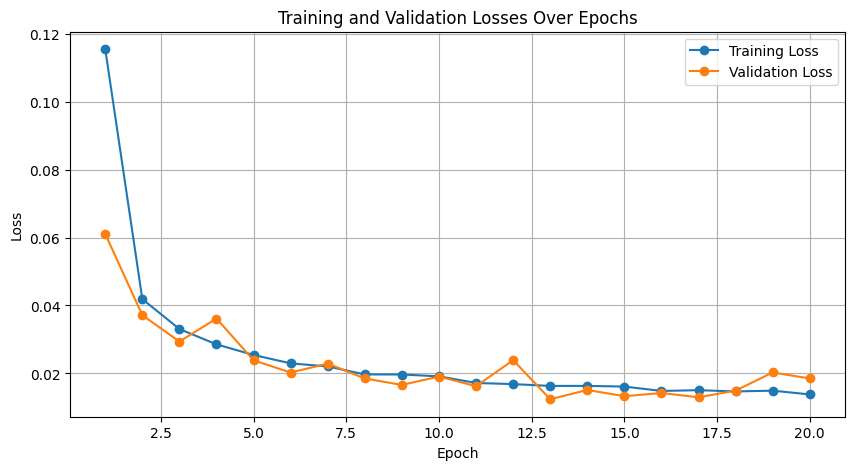

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming y_true and y_pred are the lists of true and predicted labels from the test set
cm = confusion_matrix(y_true, y_pred)
class_accuracy = 100 * cm.diagonal() / cm.sum(axis=1)  # Calculate accuracy per class in percentage

# Print class accuracies
class_labels = encoder.classes_  # Assuming encoder is your LabelEncoder instance used earlier
for label, accuracy in zip(class_labels, class_accuracy):
    print(f'Accuracy for class {label}: {accuracy:.2f}%')


Accuracy for class 0: 98.42%
Accuracy for class 1: 84.06%
Accuracy for class 2: 100.00%
Accuracy for class 3: 100.00%
Accuracy for class 4: 80.00%
Accuracy for class 5: 66.67%
Accuracy for class 6: 100.00%
Accuracy for class 7: 100.00%
Accuracy for class 8: 97.40%
Accuracy for class 9: 100.00%
Accuracy for class 10: 96.27%
Accuracy for class 11: 77.08%


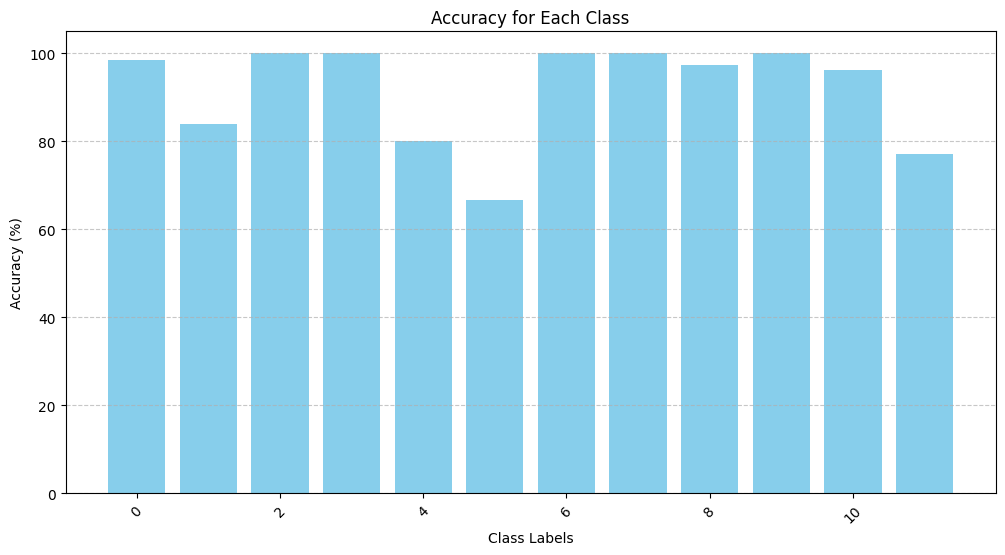

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(class_labels, class_accuracy, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each Class')
plt.xticks(rotation=45)  # Rotate class labels for better visibility if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
